<a href="https://colab.research.google.com/github/PrathameshPawar119/techhack-traffic-ms/blob/main/techhack_tms_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd


In [2]:
import os
for dirname, _, filenames in os.walk('/content/traffic.csv'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
!pip install tensorflow==2.12.0
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
data = pd.read_csv("../content/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [9]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

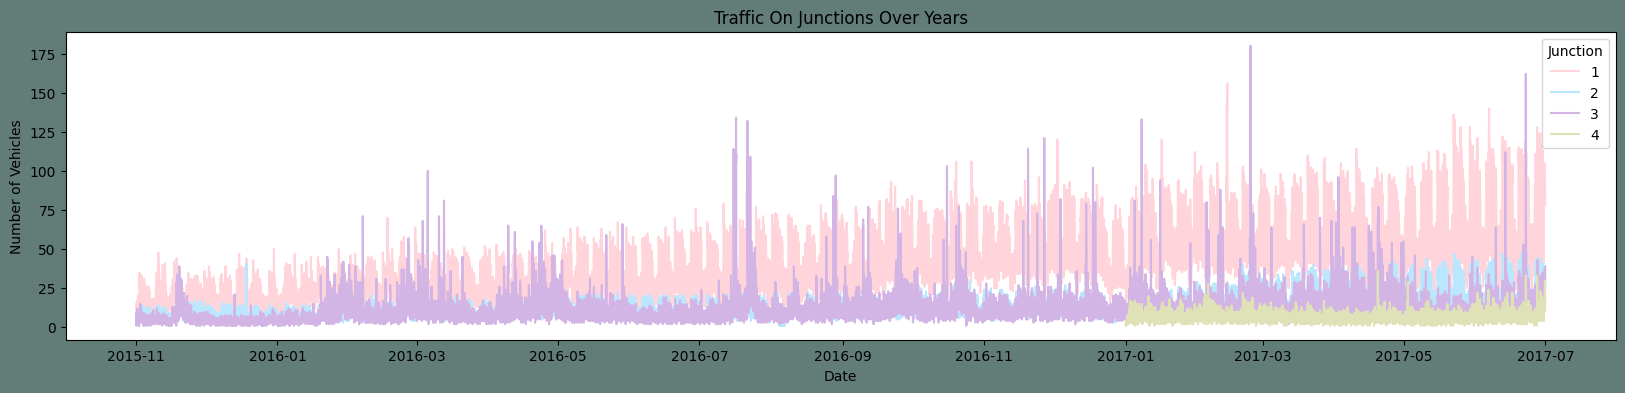

In [10]:
df=data.copy() 
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [11]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


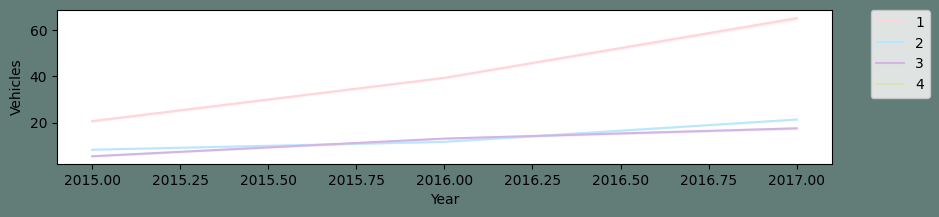

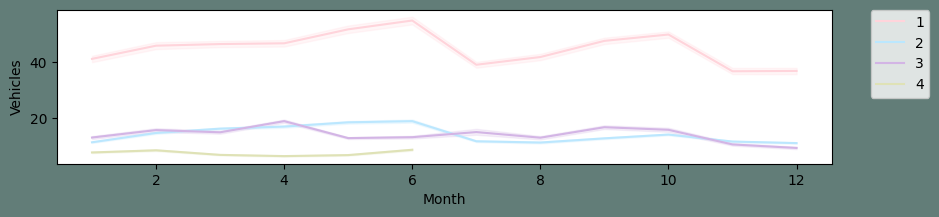

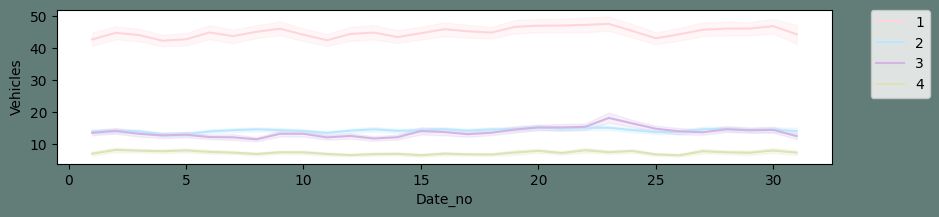

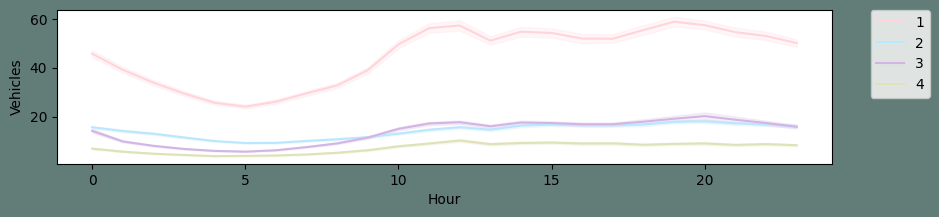

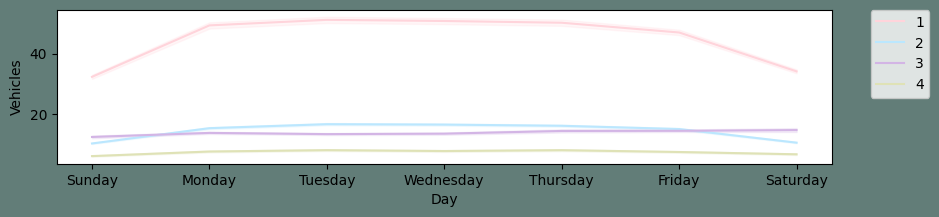

In [12]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

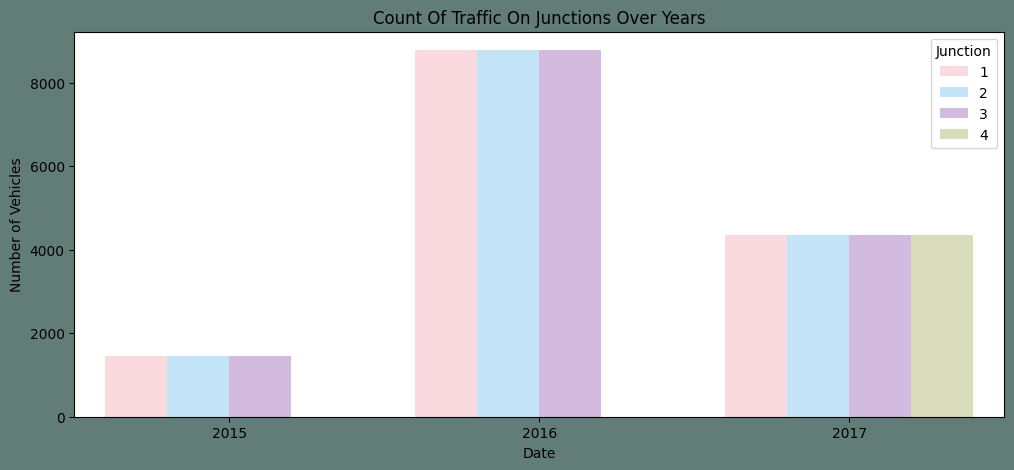

In [13]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

<Axes: >

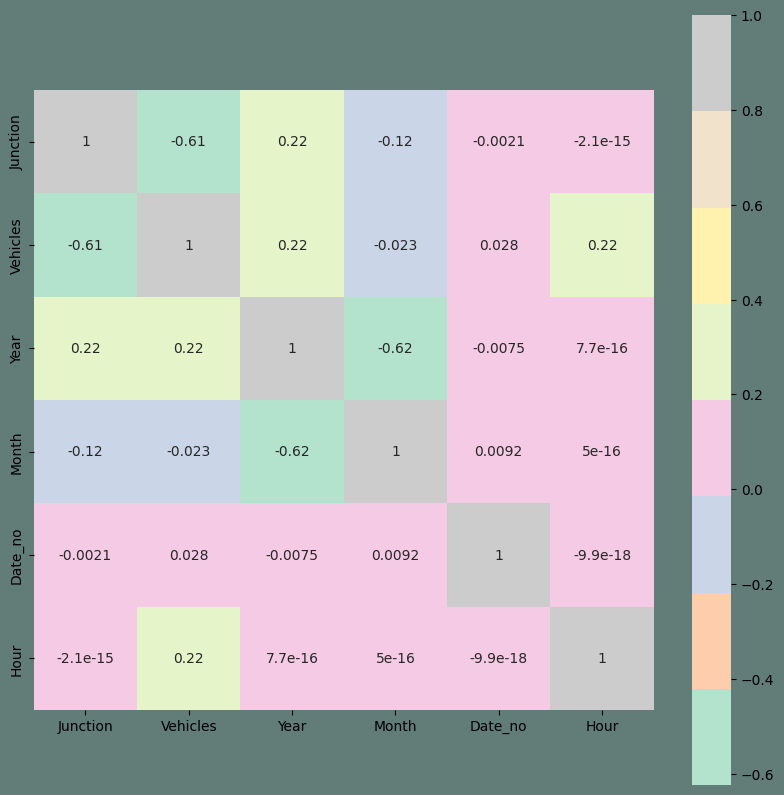

In [14]:
corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

In [15]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

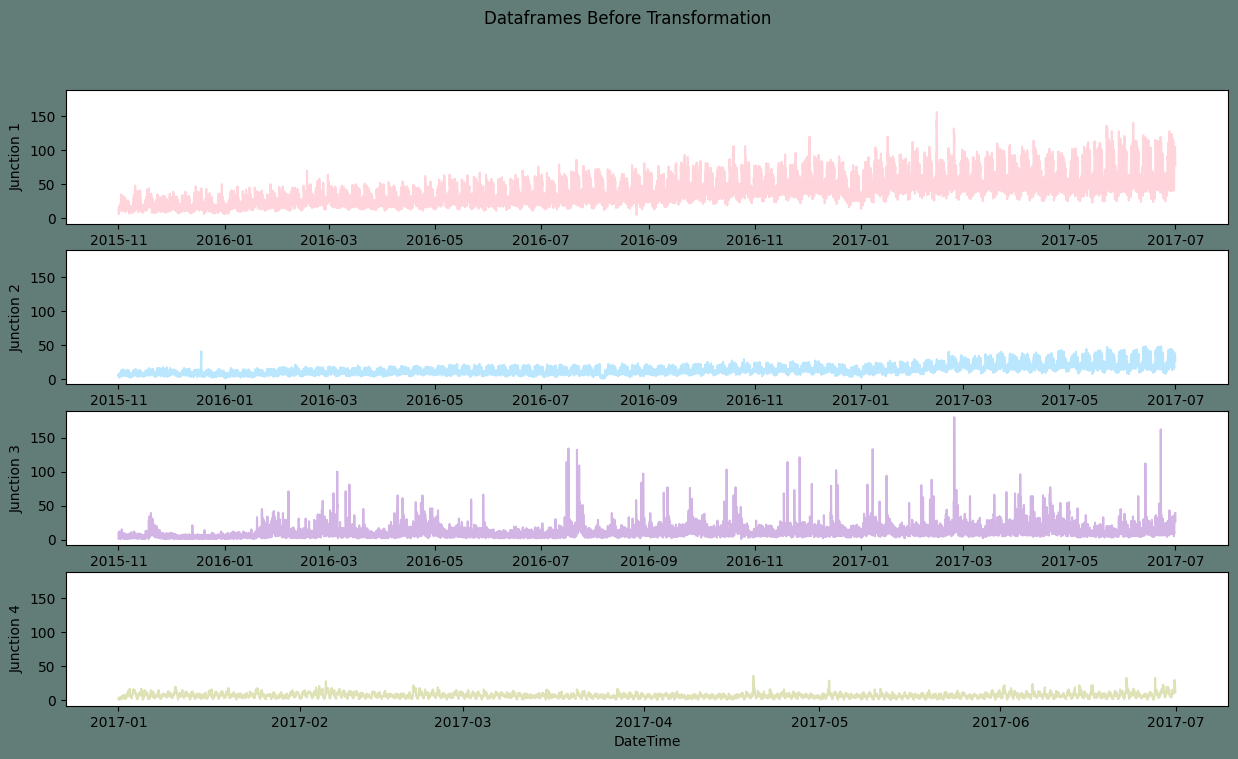

In [16]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)   
    
#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [17]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [18]:
# normalizing 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

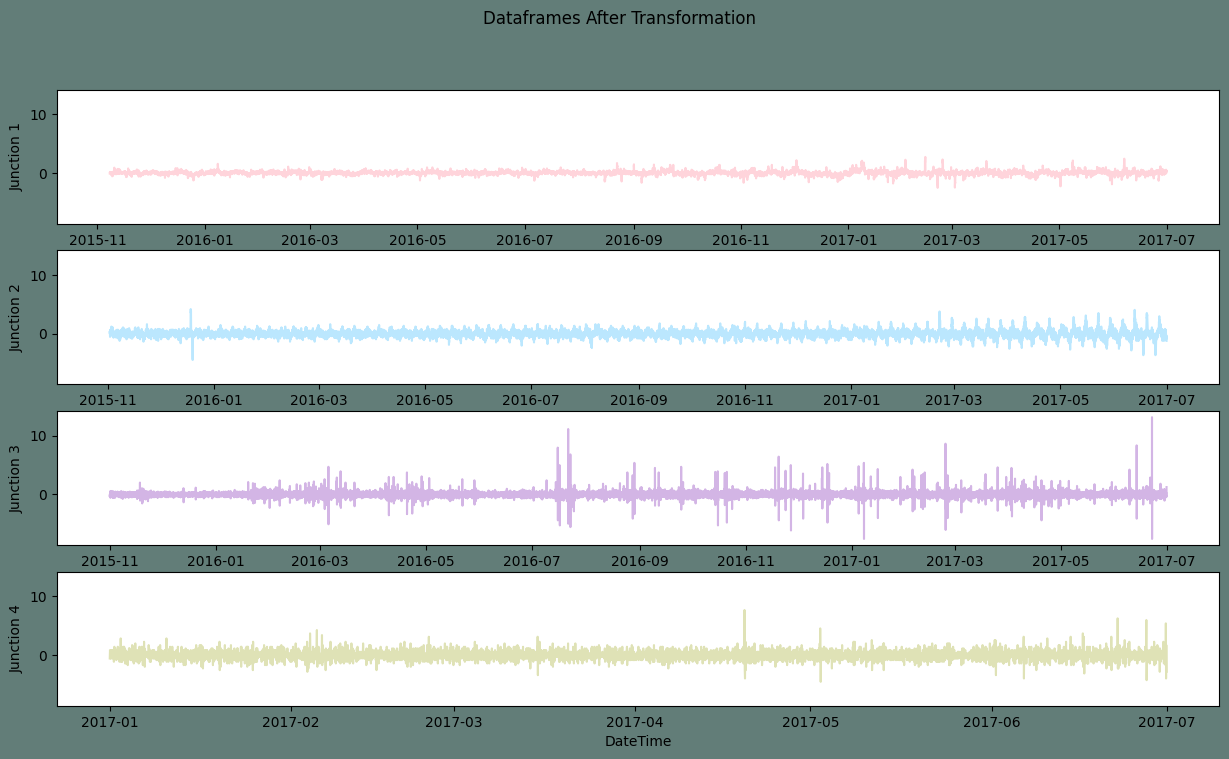

In [19]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [20]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [21]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [48]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=Adam(learning_rate=1e-7, beta_1=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    model.save('model.h5')
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [58]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)


Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.1047

87/87 [==============================] - 47s 397ms/step - loss: 0.1047
Epoch 2/50
87/87 [==============================] - ETA: 0s - loss: 0.1047

87/87 [==============================] - 36s 405ms/step - loss: 0.1047
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 0.1045

87/87 [==============================] - 36s 420ms/step - loss: 0.1045
Epoch 4/50
87/87 [==============================] - ETA: 0s - loss: 0.1043

87/87 [==============================] - 35s 407ms/step - loss: 0.1043
Epoch 5/50
87/87 [==============================] - ETA: 0s - loss: 0.1042

87/87 [==============================] - 35s 408ms/step - loss: 0.1042
Epoch 6/50
87/87 [==============================] - ETA: 0s - loss: 0.1040

87/87 [==============================] - 37s 421ms/step - loss: 0.1040
Epoch 7/50
87/87 [==============================] - ETA: 0s - loss: 0.1039

87/87 [==============================] - 35s 395ms/step - loss: 0.1039
Epoch 8/50
87/87 [==============================] - ETA: 0s - loss: 0.1039

87/87 [==============================] - 36s 411ms/step - loss: 0.1039
Epoch 9/50
87/87 [==============================] - ETA: 0s - loss: 0.1036

87/87 [==============================] - 36s 411ms/step - loss: 0.1036
Epoch 10/50
87/87 [==============================] - ETA: 0s - loss: 0.1035

87/87 [==============================] - 37s 425ms/step - loss: 0.1035
Epoch 11/50
87/87 [==============================] - ETA: 0s - loss: 0.1033

87/87 [==============================] - 38s 435ms/step - loss: 0.1033
Epoch 12/50
87/87 [==============================] - ETA: 0s - loss: 0.1035

87/87 [==============================] - 36s 410ms/step - loss: 0.1035
Epoch 13/50
87/87 [==============================] - ETA: 0s - loss: 0.1032

87/87 [==============================] - 34s 393ms/step - loss: 0.1032
Epoch 14/50
87/87 [==============================] - ETA: 0s - loss: 0.1031

87/87 [==============================] - 36s 409ms/step - loss: 0.1031
Epoch 15/50
87/87 [==============================] - ETA: 0s - loss: 0.1029

87/87 [==============================] - 36s 412ms/step - loss: 0.1029
Epoch 16/50
87/87 [==============================] - ETA: 0s - loss: 0.1028

87/87 [==============================] - 37s 427ms/step - loss: 0.1028
Epoch 17/50
87/87 [==============================] - ETA: 0s - loss: 0.1026

87/87 [==============================] - 36s 411ms/step - loss: 0.1026
Epoch 18/50
87/87 [==============================] - ETA: 0s - loss: 0.1025

87/87 [==============================] - 35s 405ms/step - loss: 0.1025
Epoch 19/50
87/87 [==============================] - ETA: 0s - loss: 0.1023

87/87 [==============================] - 37s 423ms/step - loss: 0.1023
Epoch 20/50
87/87 [==============================] - ETA: 0s - loss: 0.1022

87/87 [==============================] - 36s 409ms/step - loss: 0.1022
Epoch 21/50
87/87 [==============================] - ETA: 0s - loss: 0.1021

87/87 [==============================] - 37s 428ms/step - loss: 0.1021
Epoch 22/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 36s 412ms/step - loss: 0.1020
Epoch 23/50
87/87 [==============================] - ETA: 0s - loss: 0.1017

87/87 [==============================] - 35s 407ms/step - loss: 0.1017
Epoch 24/50
87/87 [==============================] - ETA: 0s - loss: 0.1017

87/87 [==============================] - 35s 396ms/step - loss: 0.1017
Epoch 25/50
87/87 [==============================] - ETA: 0s - loss: 0.1016

87/87 [==============================] - 36s 411ms/step - loss: 0.1016
Epoch 26/50
87/87 [==============================] - ETA: 0s - loss: 0.1015

87/87 [==============================] - 37s 426ms/step - loss: 0.1015
Epoch 27/50
87/87 [==============================] - ETA: 0s - loss: 0.1013

87/87 [==============================] - 37s 431ms/step - loss: 0.1013
Epoch 28/50
87/87 [==============================] - ETA: 0s - loss: 0.1012

87/87 [==============================] - 36s 414ms/step - loss: 0.1012
Epoch 29/50
87/87 [==============================] - ETA: 0s - loss: 0.1011

87/87 [==============================] - 35s 407ms/step - loss: 0.1011
Epoch 30/50
87/87 [==============================] - ETA: 0s - loss: 0.1009

87/87 [==============================] - 35s 397ms/step - loss: 0.1009
Epoch 31/50
87/87 [==============================] - ETA: 0s - loss: 0.1009

87/87 [==============================] - 37s 424ms/step - loss: 0.1009
Epoch 32/50
87/87 [==============================] - ETA: 0s - loss: 0.1007

87/87 [==============================] - 36s 412ms/step - loss: 0.1007
Epoch 33/50
87/87 [==============================] - ETA: 0s - loss: 0.1006

87/87 [==============================] - 36s 413ms/step - loss: 0.1006
Epoch 34/50
87/87 [==============================] - ETA: 0s - loss: 0.1004

87/87 [==============================] - 36s 410ms/step - loss: 0.1004
Epoch 35/50
87/87 [==============================] - ETA: 0s - loss: 0.1004

87/87 [==============================] - 37s 430ms/step - loss: 0.1004
Epoch 36/50
87/87 [==============================] - ETA: 0s - loss: 0.1003

87/87 [==============================] - 36s 415ms/step - loss: 0.1003
Epoch 37/50
87/87 [==============================] - ETA: 0s - loss: 0.1001

87/87 [==============================] - 36s 413ms/step - loss: 0.1001
Epoch 38/50
87/87 [==============================] - ETA: 0s - loss: 0.1000

87/87 [==============================] - 36s 414ms/step - loss: 0.1000
Epoch 39/50
87/87 [==============================] - ETA: 0s - loss: 0.1000

87/87 [==============================] - 36s 416ms/step - loss: 0.1000
Epoch 40/50
87/87 [==============================] - ETA: 0s - loss: 0.0998

87/87 [==============================] - 36s 415ms/step - loss: 0.0998
Epoch 41/50
87/87 [==============================] - ETA: 0s - loss: 0.0997

87/87 [==============================] - 36s 418ms/step - loss: 0.0997
Epoch 42/50
87/87 [==============================] - ETA: 0s - loss: 0.0996

87/87 [==============================] - 35s 404ms/step - loss: 0.0996
Epoch 43/50
87/87 [==============================] - ETA: 0s - loss: 0.0995

87/87 [==============================] - 37s 429ms/step - loss: 0.0995
Epoch 44/50
87/87 [==============================] - ETA: 0s - loss: 0.0993

87/87 [==============================] - 36s 414ms/step - loss: 0.0993
Epoch 45/50
87/87 [==============================] - ETA: 0s - loss: 0.0991

87/87 [==============================] - 36s 419ms/step - loss: 0.0991
Epoch 46/50
87/87 [==============================] - ETA: 0s - loss: 0.0991

87/87 [==============================] - 37s 428ms/step - loss: 0.0991
Epoch 47/50
87/87 [==============================] - ETA: 0s - loss: 0.0990

87/87 [==============================] - 36s 414ms/step - loss: 0.0990
Epoch 48/50
87/87 [==============================] - ETA: 0s - loss: 0.0989

87/87 [==============================] - 35s 406ms/step - loss: 0.0989
Epoch 49/50
87/87 [==============================] - ETA: 0s - loss: 0.0987

87/87 [==============================] - 36s 407ms/step - loss: 0.0987
Epoch 50/50
87/87 [==============================] - ETA: 0s - loss: 0.0987

45/45 [==============================] - 5s 77ms/step


The root mean squared error is 0.3384604082029275.


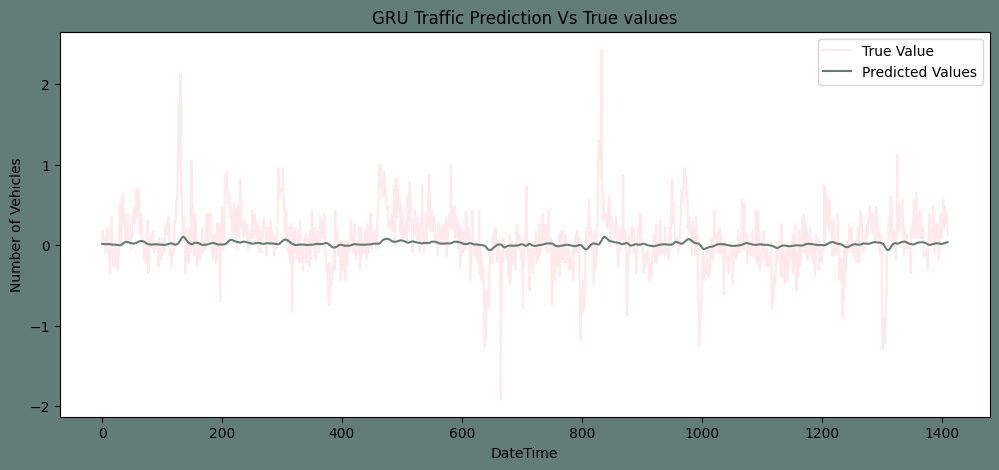

In [31]:
#Results for J1 
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

In [32]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.3181

88/88 [==============================] - 58s 506ms/step - loss: 0.3181
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 0.3182

88/88 [==============================] - 39s 437ms/step - loss: 0.3182
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 0.3176

88/88 [==============================] - 44s 498ms/step - loss: 0.3176
Epoch 4/50
88/88 [==============================] - ETA: 0s - loss: 0.3176

88/88 [==============================] - 40s 453ms/step - loss: 0.3176
Epoch 5/50
88/88 [==============================] - ETA: 0s - loss: 0.3172

88/88 [==============================] - 34s 384ms/step - loss: 0.3172
Epoch 6/50
88/88 [==============================] - ETA: 0s - loss: 0.3167

88/88 [==============================] - 37s 417ms/step - loss: 0.3167
Epoch 7/50
88/88 [==============================] - ETA: 0s - loss: 0.3165

88/88 [==============================] - 36s 408ms/step - loss: 0.3165
Epoch 8/50
88/88 [==============================] - ETA: 0s - loss: 0.3159

88/88 [==============================] - 34s 391ms/step - loss: 0.3159
Epoch 9/50
88/88 [==============================] - ETA: 0s - loss: 0.3158

88/88 [==============================] - 34s 385ms/step - loss: 0.3158
Epoch 10/50
88/88 [==============================] - ETA: 0s - loss: 0.3156

88/88 [==============================] - 34s 388ms/step - loss: 0.3156
Epoch 11/50
88/88 [==============================] - ETA: 0s - loss: 0.3154

88/88 [==============================] - 33s 379ms/step - loss: 0.3154
Epoch 12/50
88/88 [==============================] - ETA: 0s - loss: 0.3148

88/88 [==============================] - 33s 376ms/step - loss: 0.3148
Epoch 13/50
88/88 [==============================] - ETA: 0s - loss: 0.3148

88/88 [==============================] - 34s 386ms/step - loss: 0.3148
Epoch 14/50
88/88 [==============================] - ETA: 0s - loss: 0.3148

88/88 [==============================] - 34s 386ms/step - loss: 0.3148
Epoch 15/50
88/88 [==============================] - ETA: 0s - loss: 0.3144

88/88 [==============================] - 34s 386ms/step - loss: 0.3144
Epoch 16/50
88/88 [==============================] - ETA: 0s - loss: 0.3140

88/88 [==============================] - 34s 387ms/step - loss: 0.3140
Epoch 17/50
88/88 [==============================] - ETA: 0s - loss: 0.3139

88/88 [==============================] - 34s 388ms/step - loss: 0.3139
Epoch 18/50
88/88 [==============================] - ETA: 0s - loss: 0.3135

88/88 [==============================] - 33s 377ms/step - loss: 0.3135
Epoch 19/50
88/88 [==============================] - ETA: 0s - loss: 0.3131

88/88 [==============================] - 34s 387ms/step - loss: 0.3131
Epoch 20/50
88/88 [==============================] - ETA: 0s - loss: 0.3131

88/88 [==============================] - 34s 392ms/step - loss: 0.3131
Epoch 21/50
88/88 [==============================] - ETA: 0s - loss: 0.3126

88/88 [==============================] - 34s 388ms/step - loss: 0.3126
Epoch 22/50
88/88 [==============================] - ETA: 0s - loss: 0.3124

88/88 [==============================] - 34s 387ms/step - loss: 0.3124
Epoch 23/50
88/88 [==============================] - ETA: 0s - loss: 0.3120

88/88 [==============================] - 34s 388ms/step - loss: 0.3120
Epoch 24/50
88/88 [==============================] - ETA: 0s - loss: 0.3116

88/88 [==============================] - 34s 390ms/step - loss: 0.3116
Epoch 25/50
88/88 [==============================] - ETA: 0s - loss: 0.3116

88/88 [==============================] - 38s 435ms/step - loss: 0.3116
Epoch 26/50
88/88 [==============================] - ETA: 0s - loss: 0.3110

88/88 [==============================] - 34s 387ms/step - loss: 0.3110
Epoch 27/50
88/88 [==============================] - ETA: 0s - loss: 0.3109

88/88 [==============================] - 34s 385ms/step - loss: 0.3109
Epoch 28/50
88/88 [==============================] - ETA: 0s - loss: 0.3108

88/88 [==============================] - 35s 389ms/step - loss: 0.3108
Epoch 29/50
88/88 [==============================] - ETA: 0s - loss: 0.3102

88/88 [==============================] - 34s 389ms/step - loss: 0.3102
Epoch 30/50
88/88 [==============================] - ETA: 0s - loss: 0.3105

88/88 [==============================] - 35s 397ms/step - loss: 0.3105
Epoch 31/50
88/88 [==============================] - ETA: 0s - loss: 0.3097

88/88 [==============================] - 35s 394ms/step - loss: 0.3097
Epoch 32/50
88/88 [==============================] - ETA: 0s - loss: 0.3096

88/88 [==============================] - 34s 388ms/step - loss: 0.3096
Epoch 33/50
88/88 [==============================] - ETA: 0s - loss: 0.3092

88/88 [==============================] - 34s 387ms/step - loss: 0.3092
Epoch 34/50
88/88 [==============================] - ETA: 0s - loss: 0.3089

88/88 [==============================] - 35s 398ms/step - loss: 0.3089
Epoch 35/50
88/88 [==============================] - ETA: 0s - loss: 0.3086

88/88 [==============================] - 34s 386ms/step - loss: 0.3086
Epoch 36/50
88/88 [==============================] - ETA: 0s - loss: 0.3083

88/88 [==============================] - 34s 390ms/step - loss: 0.3083
Epoch 37/50
88/88 [==============================] - ETA: 0s - loss: 0.3082

88/88 [==============================] - 34s 386ms/step - loss: 0.3082
Epoch 38/50
88/88 [==============================] - ETA: 0s - loss: 0.3080

88/88 [==============================] - 35s 390ms/step - loss: 0.3080
Epoch 39/50
88/88 [==============================] - ETA: 0s - loss: 0.3075

88/88 [==============================] - 34s 389ms/step - loss: 0.3075
Epoch 40/50
88/88 [==============================] - ETA: 0s - loss: 0.3072

88/88 [==============================] - 35s 399ms/step - loss: 0.3072
Epoch 41/50
88/88 [==============================] - ETA: 0s - loss: 0.3067

88/88 [==============================] - 34s 389ms/step - loss: 0.3067
Epoch 42/50
88/88 [==============================] - ETA: 0s - loss: 0.3069

88/88 [==============================] - 34s 388ms/step - loss: 0.3069
Epoch 43/50
88/88 [==============================] - ETA: 0s - loss: 0.3063

88/88 [==============================] - 34s 387ms/step - loss: 0.3063
Epoch 44/50
88/88 [==============================] - ETA: 0s - loss: 0.3065

88/88 [==============================] - 34s 386ms/step - loss: 0.3065
Epoch 45/50
88/88 [==============================] - ETA: 0s - loss: 0.3057

88/88 [==============================] - 35s 394ms/step - loss: 0.3057
Epoch 46/50
88/88 [==============================] - ETA: 0s - loss: 0.3058

88/88 [==============================] - 33s 374ms/step - loss: 0.3058
Epoch 47/50
88/88 [==============================] - ETA: 0s - loss: 0.3050

88/88 [==============================] - 34s 385ms/step - loss: 0.3050
Epoch 48/50
88/88 [==============================] - ETA: 0s - loss: 0.3053

88/88 [==============================] - 34s 388ms/step - loss: 0.3053
Epoch 49/50
88/88 [==============================] - ETA: 0s - loss: 0.3049

88/88 [==============================] - 34s 386ms/step - loss: 0.3049
Epoch 50/50
88/88 [==============================] - ETA: 0s - loss: 0.3046

45/45 [==============================] - 5s 67ms/step


The root mean squared error is 0.9416668216158055.


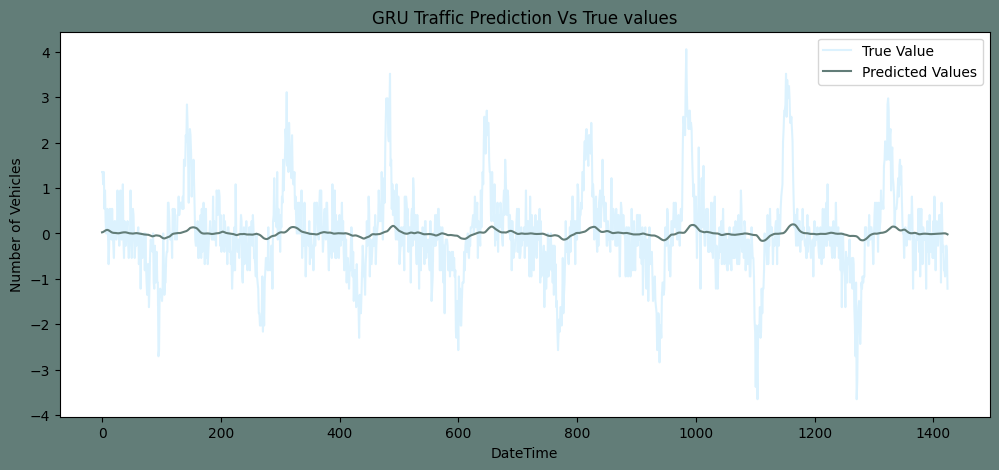

In [33]:
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [34]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3) 

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.3039

88/88 [==============================] - 47s 399ms/step - loss: 0.3039
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 0.3038

88/88 [==============================] - 35s 402ms/step - loss: 0.3038
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 0.3038

88/88 [==============================] - 35s 401ms/step - loss: 0.3038
Epoch 4/50
88/88 [==============================] - ETA: 0s - loss: 0.3038

88/88 [==============================] - 35s 400ms/step - loss: 0.3038
Epoch 5/50
88/88 [==============================] - ETA: 0s - loss: 0.3037

88/88 [==============================] - 36s 407ms/step - loss: 0.3037
Epoch 6/50
88/88 [==============================] - ETA: 0s - loss: 0.3037

88/88 [==============================] - 35s 396ms/step - loss: 0.3037
Epoch 7/50
88/88 [==============================] - ETA: 0s - loss: 0.3037

88/88 [==============================] - 35s 399ms/step - loss: 0.3037
Epoch 8/50
88/88 [==============================] - ETA: 0s - loss: 0.3037

88/88 [==============================] - 35s 396ms/step - loss: 0.3037
Epoch 9/50
88/88 [==============================] - ETA: 0s - loss: 0.3035

88/88 [==============================] - 35s 393ms/step - loss: 0.3035
Epoch 10/50
88/88 [==============================] - ETA: 0s - loss: 0.3036

88/88 [==============================] - 35s 393ms/step - loss: 0.3036
Epoch 11/50
88/88 [==============================] - ETA: 0s - loss: 0.3035

88/88 [==============================] - 36s 410ms/step - loss: 0.3035
Epoch 12/50
88/88 [==============================] - ETA: 0s - loss: 0.3035

88/88 [==============================] - 35s 397ms/step - loss: 0.3035
Epoch 13/50
88/88 [==============================] - ETA: 0s - loss: 0.3034

88/88 [==============================] - 36s 404ms/step - loss: 0.3034
Epoch 14/50
88/88 [==============================] - ETA: 0s - loss: 0.3035

88/88 [==============================] - 36s 407ms/step - loss: 0.3035
Epoch 15/50
88/88 [==============================] - ETA: 0s - loss: 0.3035

88/88 [==============================] - 36s 409ms/step - loss: 0.3035
Epoch 16/50
88/88 [==============================] - ETA: 0s - loss: 0.3033

88/88 [==============================] - 36s 414ms/step - loss: 0.3033
Epoch 17/50
88/88 [==============================] - ETA: 0s - loss: 0.3034

88/88 [==============================] - 35s 400ms/step - loss: 0.3034
Epoch 18/50
88/88 [==============================] - ETA: 0s - loss: 0.3034

88/88 [==============================] - 35s 403ms/step - loss: 0.3034
Epoch 19/50
88/88 [==============================] - ETA: 0s - loss: 0.3035

88/88 [==============================] - 35s 398ms/step - loss: 0.3035
Epoch 20/50
88/88 [==============================] - ETA: 0s - loss: 0.3034

88/88 [==============================] - 36s 409ms/step - loss: 0.3034
Epoch 21/50
88/88 [==============================] - ETA: 0s - loss: 0.3035

88/88 [==============================] - 35s 398ms/step - loss: 0.3035
Epoch 22/50
88/88 [==============================] - ETA: 0s - loss: 0.3032

88/88 [==============================] - 36s 407ms/step - loss: 0.3032
Epoch 23/50
88/88 [==============================] - ETA: 0s - loss: 0.3033

88/88 [==============================] - 35s 397ms/step - loss: 0.3033
Epoch 24/50
88/88 [==============================] - ETA: 0s - loss: 0.3032

88/88 [==============================] - 35s 401ms/step - loss: 0.3032
Epoch 25/50
88/88 [==============================] - ETA: 0s - loss: 0.3033

88/88 [==============================] - 35s 398ms/step - loss: 0.3033
Epoch 26/50
88/88 [==============================] - ETA: 0s - loss: 0.3032

88/88 [==============================] - 35s 397ms/step - loss: 0.3032
Epoch 27/50
88/88 [==============================] - ETA: 0s - loss: 0.3031

88/88 [==============================] - 36s 408ms/step - loss: 0.3031
Epoch 28/50
88/88 [==============================] - ETA: 0s - loss: 0.3032

88/88 [==============================] - 36s 404ms/step - loss: 0.3032
Epoch 29/50
88/88 [==============================] - ETA: 0s - loss: 0.3031

88/88 [==============================] - 35s 402ms/step - loss: 0.3031
Epoch 30/50
88/88 [==============================] - ETA: 0s - loss: 0.3031

88/88 [==============================] - 36s 406ms/step - loss: 0.3031
Epoch 31/50
88/88 [==============================] - ETA: 0s - loss: 0.3031

88/88 [==============================] - 36s 411ms/step - loss: 0.3031
Epoch 32/50
88/88 [==============================] - ETA: 0s - loss: 0.3030

88/88 [==============================] - 36s 407ms/step - loss: 0.3030
Epoch 33/50
88/88 [==============================] - ETA: 0s - loss: 0.3030

88/88 [==============================] - 37s 418ms/step - loss: 0.3030
Epoch 34/50
88/88 [==============================] - ETA: 0s - loss: 0.3030

88/88 [==============================] - 36s 407ms/step - loss: 0.3030
Epoch 35/50
88/88 [==============================] - ETA: 0s - loss: 0.3029

88/88 [==============================] - 36s 405ms/step - loss: 0.3029
Epoch 36/50
88/88 [==============================] - ETA: 0s - loss: 0.3031

88/88 [==============================] - 36s 406ms/step - loss: 0.3031
Epoch 37/50
88/88 [==============================] - ETA: 0s - loss: 0.3030

88/88 [==============================] - 35s 403ms/step - loss: 0.3030
Epoch 38/50
88/88 [==============================] - ETA: 0s - loss: 0.3031

88/88 [==============================] - 37s 419ms/step - loss: 0.3031
Epoch 39/50
88/88 [==============================] - ETA: 0s - loss: 0.3029

88/88 [==============================] - 36s 409ms/step - loss: 0.3029
Epoch 40/50
88/88 [==============================] - ETA: 0s - loss: 0.3030

88/88 [==============================] - 36s 408ms/step - loss: 0.3030
Epoch 41/50
88/88 [==============================] - ETA: 0s - loss: 0.3029

88/88 [==============================] - 37s 417ms/step - loss: 0.3029
Epoch 42/50
88/88 [==============================] - ETA: 0s - loss: 0.3028

88/88 [==============================] - 36s 411ms/step - loss: 0.3028
Epoch 43/50
88/88 [==============================] - ETA: 0s - loss: 0.3027

88/88 [==============================] - 37s 422ms/step - loss: 0.3027
Epoch 44/50
88/88 [==============================] - ETA: 0s - loss: 0.3029

88/88 [==============================] - 36s 408ms/step - loss: 0.3029
Epoch 45/50
88/88 [==============================] - ETA: 0s - loss: 0.3028

88/88 [==============================] - 36s 409ms/step - loss: 0.3028
Epoch 46/50
88/88 [==============================] - ETA: 0s - loss: 0.3028

88/88 [==============================] - 36s 407ms/step - loss: 0.3028
Epoch 47/50
88/88 [==============================] - ETA: 0s - loss: 0.3028

88/88 [==============================] - 36s 405ms/step - loss: 0.3028
Epoch 48/50
88/88 [==============================] - ETA: 0s - loss: 0.3027

88/88 [==============================] - 36s 412ms/step - loss: 0.3027
Epoch 49/50
88/88 [==============================] - ETA: 0s - loss: 0.3028

88/88 [==============================] - 36s 405ms/step - loss: 0.3028
Epoch 50/50
88/88 [==============================] - ETA: 0s - loss: 0.3026

45/45 [==============================] - 4s 45ms/step


The root mean squared error is 0.6337883112081221.


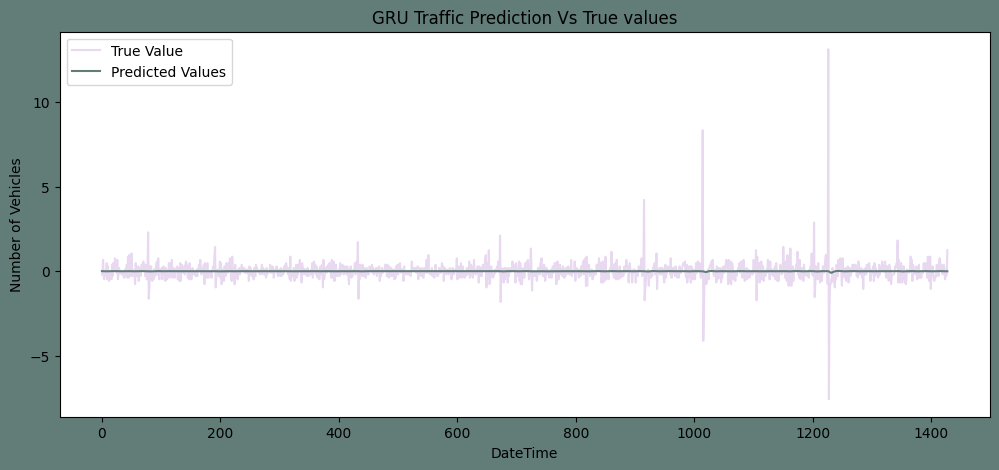

In [35]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [36]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 0.6883

26/26 [==============================] - 21s 394ms/step - loss: 0.6883
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 393ms/step - loss: 0.6884
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.6885

26/26 [==============================] - 10s 392ms/step - loss: 0.6885
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 0.6887

26/26 [==============================] - 10s 393ms/step - loss: 0.6887
Epoch 5/50
26/26 [==============================] - ETA: 0s - loss: 0.6886

26/26 [==============================] - 10s 368ms/step - loss: 0.6886
Epoch 6/50
26/26 [==============================] - ETA: 0s - loss: 0.6886

26/26 [==============================] - 11s 399ms/step - loss: 0.6886
Epoch 7/50
26/26 [==============================] - ETA: 0s - loss: 0.6885

26/26 [==============================] - 11s 423ms/step - loss: 0.6885
Epoch 8/50
26/26 [==============================] - ETA: 0s - loss: 0.6886

26/26 [==============================] - 10s 392ms/step - loss: 0.6886
Epoch 9/50
26/26 [==============================] - ETA: 0s - loss: 0.6885

26/26 [==============================] - 10s 389ms/step - loss: 0.6885
Epoch 10/50
26/26 [==============================] - ETA: 0s - loss: 0.6883

26/26 [==============================] - 10s 385ms/step - loss: 0.6883
Epoch 11/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 393ms/step - loss: 0.6884
Epoch 12/50
26/26 [==============================] - ETA: 0s - loss: 0.6886

26/26 [==============================] - 9s 354ms/step - loss: 0.6886
Epoch 13/50
26/26 [==============================] - ETA: 0s - loss: 0.6886

26/26 [==============================] - 10s 387ms/step - loss: 0.6886
Epoch 14/50
26/26 [==============================] - ETA: 0s - loss: 0.6886

26/26 [==============================] - 10s 389ms/step - loss: 0.6886
Epoch 15/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 388ms/step - loss: 0.6884
Epoch 16/50
26/26 [==============================] - ETA: 0s - loss: 0.6885

26/26 [==============================] - 10s 382ms/step - loss: 0.6885
Epoch 17/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 388ms/step - loss: 0.6884
Epoch 18/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 9s 356ms/step - loss: 0.6884
Epoch 19/50
26/26 [==============================] - ETA: 0s - loss: 0.6881

26/26 [==============================] - 10s 386ms/step - loss: 0.6881
Epoch 20/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 387ms/step - loss: 0.6884
Epoch 21/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 385ms/step - loss: 0.6884
Epoch 22/50
26/26 [==============================] - ETA: 0s - loss: 0.6883

26/26 [==============================] - 10s 387ms/step - loss: 0.6883
Epoch 23/50
26/26 [==============================] - ETA: 0s - loss: 0.6886

26/26 [==============================] - 10s 386ms/step - loss: 0.6886
Epoch 24/50
26/26 [==============================] - ETA: 0s - loss: 0.6883

26/26 [==============================] - 9s 352ms/step - loss: 0.6883
Epoch 25/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 389ms/step - loss: 0.6884
Epoch 26/50
26/26 [==============================] - ETA: 0s - loss: 0.6882

26/26 [==============================] - 11s 424ms/step - loss: 0.6882
Epoch 27/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 385ms/step - loss: 0.6884
Epoch 28/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 384ms/step - loss: 0.6884
Epoch 29/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 389ms/step - loss: 0.6884
Epoch 30/50
26/26 [==============================] - ETA: 0s - loss: 0.6882

26/26 [==============================] - 10s 370ms/step - loss: 0.6882
Epoch 31/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 368ms/step - loss: 0.6884
Epoch 32/50
26/26 [==============================] - ETA: 0s - loss: 0.6883

26/26 [==============================] - 10s 394ms/step - loss: 0.6883
Epoch 33/50
26/26 [==============================] - ETA: 0s - loss: 0.6882

26/26 [==============================] - 10s 398ms/step - loss: 0.6882
Epoch 34/50
26/26 [==============================] - ETA: 0s - loss: 0.6882

26/26 [==============================] - 10s 397ms/step - loss: 0.6882
Epoch 35/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 392ms/step - loss: 0.6884
Epoch 36/50
26/26 [==============================] - ETA: 0s - loss: 0.6880

26/26 [==============================] - 11s 437ms/step - loss: 0.6880
Epoch 37/50
26/26 [==============================] - ETA: 0s - loss: 0.6885

26/26 [==============================] - 10s 395ms/step - loss: 0.6885
Epoch 38/50
26/26 [==============================] - ETA: 0s - loss: 0.6885

26/26 [==============================] - 9s 364ms/step - loss: 0.6885
Epoch 39/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 401ms/step - loss: 0.6884
Epoch 40/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 401ms/step - loss: 0.6884
Epoch 41/50
26/26 [==============================] - ETA: 0s - loss: 0.6882

26/26 [==============================] - 10s 402ms/step - loss: 0.6882
Epoch 42/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 394ms/step - loss: 0.6884
Epoch 43/50
26/26 [==============================] - ETA: 0s - loss: 0.6883

26/26 [==============================] - 10s 392ms/step - loss: 0.6883
Epoch 44/50
26/26 [==============================] - ETA: 0s - loss: 0.6882

26/26 [==============================] - 10s 391ms/step - loss: 0.6882
Epoch 45/50
26/26 [==============================] - ETA: 0s - loss: 0.6881

26/26 [==============================] - 11s 402ms/step - loss: 0.6881
Epoch 46/50
26/26 [==============================] - ETA: 0s - loss: 0.6885

26/26 [==============================] - 10s 375ms/step - loss: 0.6885
Epoch 47/50
26/26 [==============================] - ETA: 0s - loss: 0.6882

26/26 [==============================] - 10s 396ms/step - loss: 0.6882
Epoch 48/50
26/26 [==============================] - ETA: 0s - loss: 0.6881

26/26 [==============================] - 10s 393ms/step - loss: 0.6881
Epoch 49/50
26/26 [==============================] - ETA: 0s - loss: 0.6884

26/26 [==============================] - 10s 393ms/step - loss: 0.6884
Epoch 50/50
26/26 [==============================] - ETA: 0s - loss: 0.6883

13/13 [==============================] - 3s 57ms/step


The root mean squared error is 1.1154527062247226.


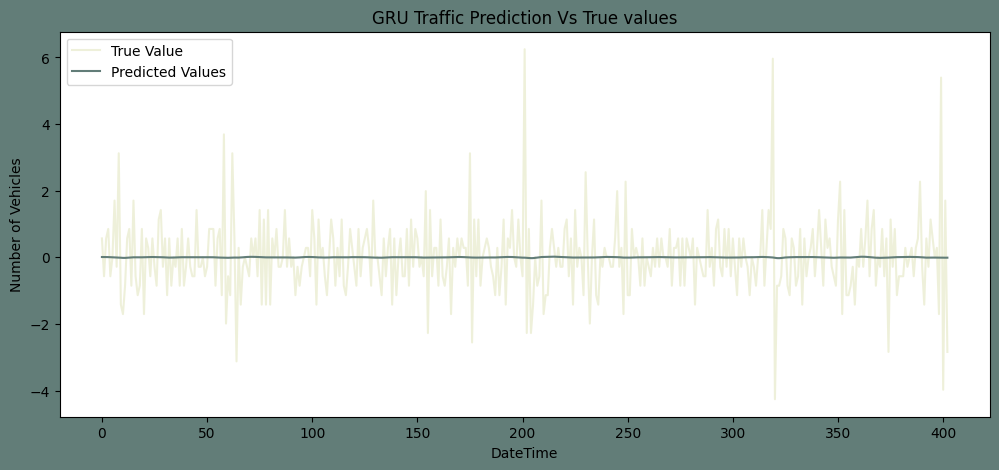

In [37]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

In [38]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

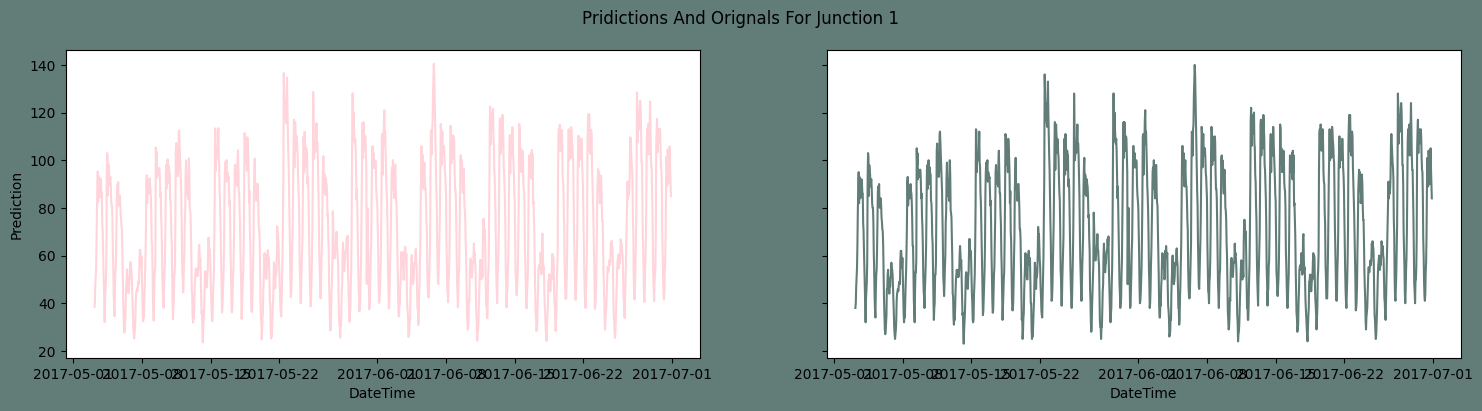

In [41]:
# invert the differenced forecast for Junction 1 
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

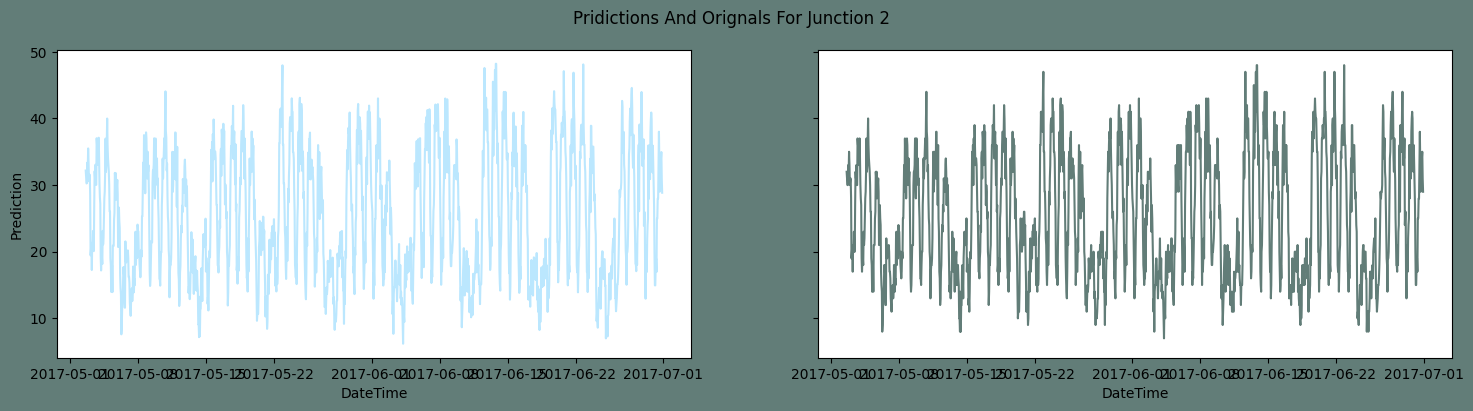

In [42]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

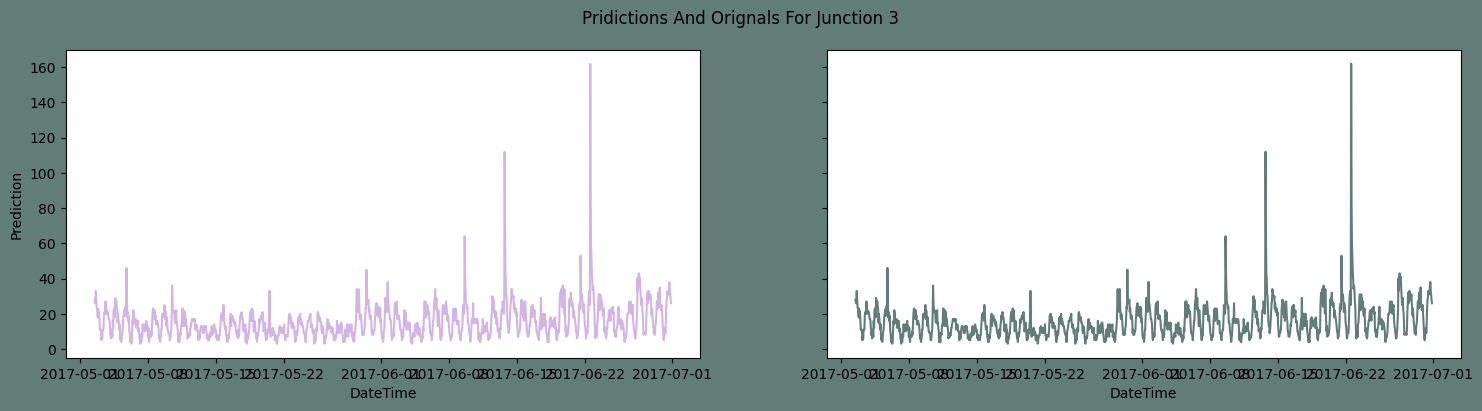

In [43]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

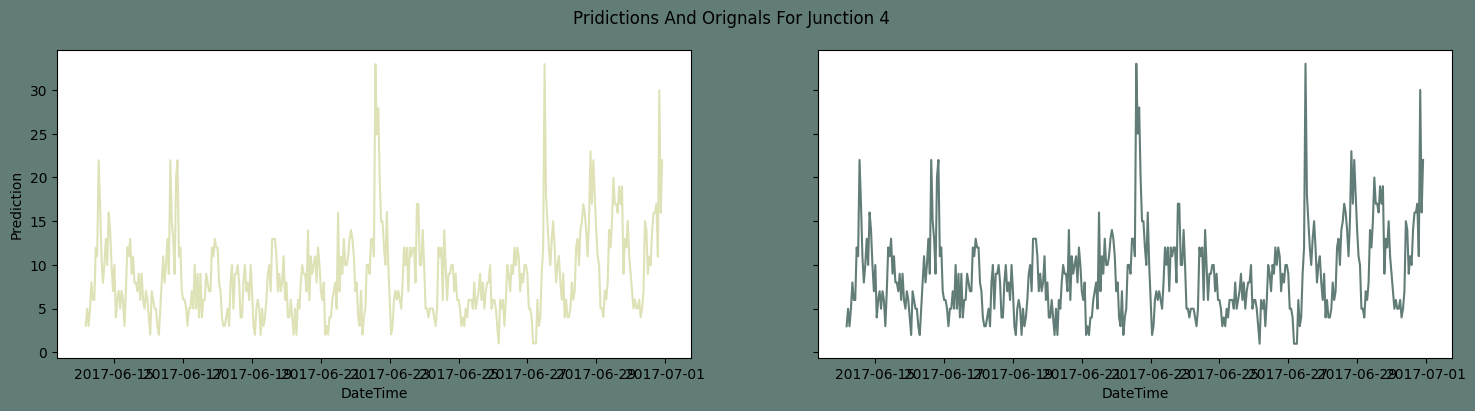

In [54]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)


In [57]:
model.save('model.h5')

NameError: ignored

In [56]:
from google.colab import files

files.download('model.h5')

FileNotFoundError: ignored